# Assignment By Xingyi Li z5394676

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

In [2]:
# we read the data
df = pd.read_csv('dataset.tsv', sep='\t')

print(f'dataset shape: {df.shape}')
print(f'column names: {list(df.columns)}')
print('\nfirst 5 lines:\n')
df.head()

dataset shape: (1500, 6)
column names: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']

first 5 lines:



,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark


In [3]:
# basic data analysis
print("Data types and non-null counts:")
display(df.info())
print("\nMissing values per column:")
display(df.isnull().sum())

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1500 non-null   object
 1   track_name    1500 non-null   object
 2   release_date  1500 non-null   int64 
 3   genre         1500 non-null   object
 4   lyrics        1500 non-null   object
 5   topic         1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB


None


Missing values per column:


artist_name     0
track_name      0
release_date    0
genre           0
lyrics          0
topic           0
dtype: int64

In [4]:
## analyze each feature's distribution
print(f'Number of unique values for each feature')
for col in df.columns:
    print(f'{col}: {df[col].nunique()}')

print("\nGenre distribution:")
print(df['genre'].value_counts())

print("\nTopic distribution:")
print(df['topic'].value_counts())


Number of unique values for each feature
artist_name: 803
track_name: 1449
release_date: 4
genre: 7
lyrics: 1480
topic: 5

Genre distribution:
genre
blues      346
rock       310
jazz       234
pop        213
reggae     177
country    176
hip hop     44
Name: count, dtype: int64

Topic distribution:
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64


In [5]:
# lyrics text statistics
df['lyrics_length'] = df['lyrics'].apply(lambda x: len(str(x).split()))
print("Lyrics length statistics (number of words):")
print(df['lyrics_length'].describe())
print("\nTop 5 longest lyrics (by number of words):")
print(df[['track_name', 'lyrics_length']].sort_values(by='lyrics_length', ascending=False).head())
print("\nTop 5 shortest lyrics (by number of words):")
print(df[['track_name', 'lyrics_length']].sort_values(by='lyrics_length', ascending=True).head())
print(f"\nNumber of empty lyrics: {(df['lyrics'].str.strip() == '').sum()}")

Lyrics length statistics (number of words):
count    1500.000000
mean       77.280667
std        38.905668
min         1.000000
25%        46.750000
50%        74.000000
75%       101.000000
max       197.000000
Name: lyrics_length, dtype: float64

Top 5 longest lyrics (by number of words):
                                  track_name  lyrics_length
865  scared of the dark (feat. xxxtentacion)            197
266                                  rise up            197
990                             living it up            197
24                           be a g about it            194
30                               traumatized            194

Top 5 shortest lyrics (by number of words):
                  track_name  lyrics_length
903            feel this way              1
635        wanna don't wanna              4
724  the morning, you & love              5
672        she said she said              6
386    quick musical doodles              6

Number of empty lyrics: 0


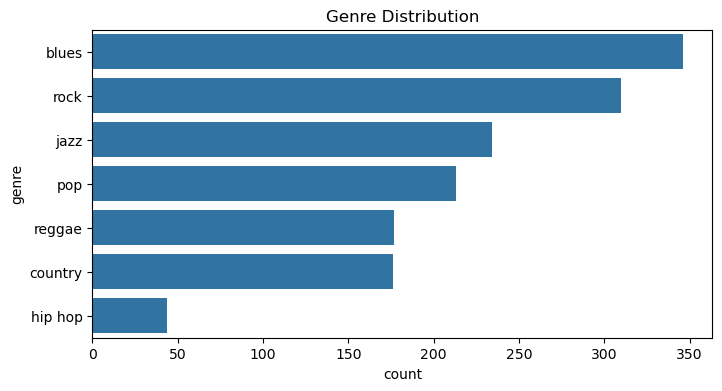

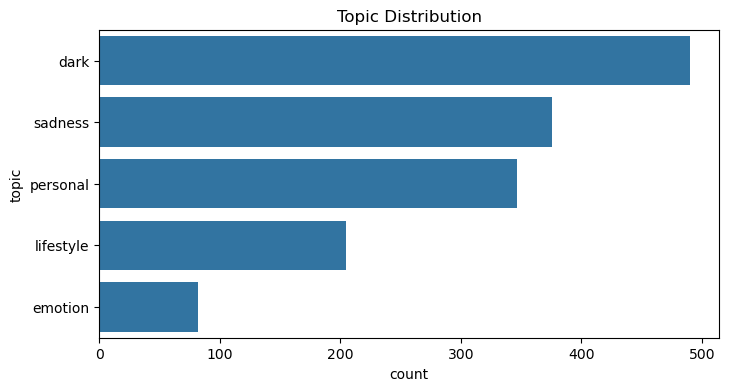

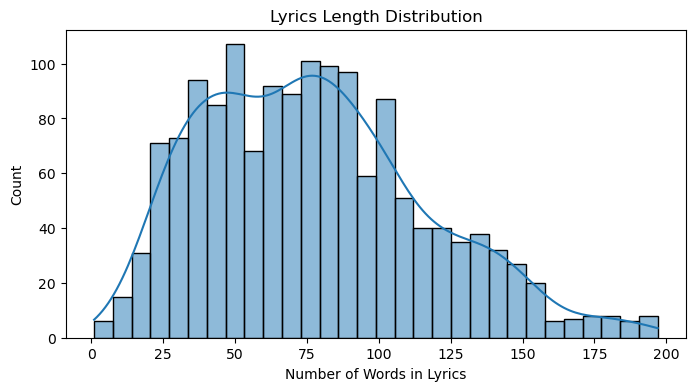

In [6]:
plt.figure(figsize=(8,4))
sns.countplot(y='genre', data=df, order=df['genre'].value_counts().index)
plt.title('Genre Distribution')
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(y='topic', data=df, order=df['topic'].value_counts().index)
plt.title('Topic Distribution')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['lyrics_length'], bins=30, kde=True)
plt.title('Lyrics Length Distribution')
plt.xlabel('Number of Words in Lyrics')
plt.ylabel('Count')
plt.show()

# Part 1

### Part 1.1
> 1. I refined the regex to keep meaningful characters such as apostrophes within words, which helps preserve the meaning of the lyrics.
> 2. I replaced the single train-test split with 5-fold cross-validation to provide a more robust and reliable evaluation of model performance.
> The code in the following sections will use these improved methods.

In [9]:
def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^\w\s']", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['lyrics_clean'] = df['lyrics'].apply(clean_text)


In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['lyrics_clean'])
y = df['topic']

model = MultinomialNB()
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation accuracy: 0.7900 ± 0.0249


## Part 1.2
> To systematically determine the best preprocessing pipeline for text classification, I designed experiments to compare the different preprocessing.
> The best preprocessing pipeline is:
> - Keep emotion-related symbols
> - Tokenize using NLTK's word_tokenize
> - Remove stopwords using NLTK's English stopword list.
> - Convert all text to lowercase.
> - Lemmatize using NLTK's WordNetLemmatizer.
>
> This combination preserves the most information and improves classification accuracy. All further experiments will use this preprocessing pipeline.

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rachel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rachel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rachel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
### Experiments to compare the different preprocessing.
def clean_text(text, keep_emotion=False):
    text = text.lower()
    if keep_emotion:
        text = re.sub(r"[^a-z\s!?]", '', text)
    else:
        text = re.sub(r"[^a-z\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text, tokenizer='nltk', stopword_set='sklearn', stem_or_lemma='lemma'):
    if tokenizer == 'nltk':
        tokens = nltk.word_tokenize(text)
    else:
        tokens = text.split()

    if stopword_set == 'nltk':
        stops = set(stopwords.words('english'))
    elif stopword_set == 'sklearn':
        stops = ENGLISH_STOP_WORDS
    else:
        stops = set()
    tokens = [t for t in tokens if t not in stops]

    if stem_or_lemma == 'stem':
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    elif stem_or_lemma == 'lemma':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

configs = [
    {'keep_emotion': True, 'tokenizer': 'nltk', 'stopword_set': 'sklearn', 'stem_or_lemma': 'lemma'},
    {'keep_emotion': False, 'tokenizer': 'nltk', 'stopword_set': 'sklearn', 'stem_or_lemma': 'lemma'},
    {'keep_emotion': True, 'tokenizer': 'nltk', 'stopword_set': 'nltk', 'stem_or_lemma': 'stem'},
    {'keep_emotion': True, 'tokenizer': 'nltk', 'stopword_set': 'nltk', 'stem_or_lemma': 'lemma'},
]

results = []
for cfg in configs:

    df['lyrics_tmp'] = df['lyrics'].apply(lambda x: clean_text(x, keep_emotion=cfg['keep_emotion']))
    df['lyrics_tmp'] = df['lyrics_tmp'].apply(lambda x: preprocess_text(x, tokenizer=cfg['tokenizer'], stopword_set=cfg['stopword_set'], stem_or_lemma=cfg['stem_or_lemma']))

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df['lyrics_tmp'])
    y = df['topic']
    
    mnb = MultinomialNB()
    acc = cross_val_score(mnb, X, y, cv=5, scoring='accuracy').mean()
    results.append((cfg, acc))

# show results
for cfg, acc in results:
    print(f"Config: {cfg}, Mean CV Accuracy: {acc:.4f}\n")

Config: {'keep_emotion': True, 'tokenizer': 'nltk', 'stopword_set': 'sklearn', 'stem_or_lemma': 'lemma'}, Mean CV Accuracy: 0.7787

Config: {'keep_emotion': False, 'tokenizer': 'nltk', 'stopword_set': 'sklearn', 'stem_or_lemma': 'lemma'}, Mean CV Accuracy: 0.7787

Config: {'keep_emotion': True, 'tokenizer': 'nltk', 'stopword_set': 'nltk', 'stem_or_lemma': 'stem'}, Mean CV Accuracy: 0.7840

Config: {'keep_emotion': True, 'tokenizer': 'nltk', 'stopword_set': 'nltk', 'stem_or_lemma': 'lemma'}, Mean CV Accuracy: 0.7880



> The results indicate that the configuration using NLTK's word_tokenize, keeping emotion-related symbols, removing stopwords with NLTK's English stopword list, and applying lemmatization with WordNetLemmatizer achieves the highest mean cross-validation accuracy (0.7880). Therefore, this preprocessing pipeline will be used for all subsequent experiments.

In [14]:
## Our preprocessing 
def keep_emotion_symbol(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s!?]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['lyrics_clean'] = df['lyrics'].apply(keep_emotion_symbol)
df['lyrics_processed'] = df['lyrics_clean'].apply(preprocess_text)

df_processed = df[['artist_name', 'track_name', 'genre', 'lyrics_processed', 'topic']].copy()
df_processed = df_processed.rename(columns={'lyrics_processed': 'lyrics'})

df_processed

,artist_name,track_name,genre,lyrics,topic
0,loving,the not real lake,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,rock,summer pretty build spill ready overflow piss ...,lifestyle
2,reignwolf,hardcore,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,blues,think think different set apart sober mind sym...,dark
...,...,...,...,...,...
1495,ra ra riot,absolutely,rock,year absolutely absolutely absolutely crush ab...,emotion
1496,mat kearney,face to face,rock,breakthrough hour hear truth moment trade fake...,dark
1497,owane,born in space,jazz,look look right catch blue eye state breath ce...,dark
1498,nappy roots,blowin' trees,hip hop,nappy root got ta alright flyin dear leave lon...,personal


## Part 1.3

> Evaluation Design
To compare Bernoulli Naive Bayes (BNB) and Multinomial Naive Bayes (MNB), I used 5-fold stratified cross-validation to ensure that the distribution of topics in each fold is as balanced as possible, as mentioned in Part 1.1.  
> In this question, I considered the following metrics:  
Accuracy: The proportion of correct predictions. It is intuitive but can be misleading for imbalanced datasets.  
Macro-averaged F1-score: Balances performance across all classes and is less affected by class imbalance.  
Macro-averaged Precision: Especially important in a recommendation scenario, as it reflects the proportion of recommended songs that are actually relevant to the user. In practice, a recommender system should prioritize precision to ensure that users are shown highly relevant results. 

In [15]:
# use the processed DataFrame and lyrics column
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_processed['lyrics'])
y = df_processed['topic']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bnb = BernoulliNB()
mnb = MultinomialNB()

bnb_acc, bnb_f1, bnb_prec = [], [], []
mnb_acc, mnb_f1, mnb_prec = [], [], []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    bnb.fit(X_train, y_train)
    y_pred_bnb = bnb.predict(X_test)
    bnb_acc.append(accuracy_score(y_test, y_pred_bnb))
    bnb_f1.append(f1_score(y_test, y_pred_bnb, average='macro'))
    bnb_prec.append(precision_score(y_test, y_pred_bnb, average='macro', zero_division=0))

    mnb.fit(X_train, y_train)
    y_pred_mnb = mnb.predict(X_test)
    mnb_acc.append(accuracy_score(y_test, y_pred_mnb))
    mnb_f1.append(f1_score(y_test, y_pred_mnb, average='macro'))
    mnb_prec.append(precision_score(y_test, y_pred_mnb, average='macro', zero_division=0))

results_bnb_mnb = pd.DataFrame({
    'Model': ['BernoulliNB', 'MultinomialNB'],
    'Mean Accuracy': [np.mean(bnb_acc), np.mean(mnb_acc)],
    'Mean Macro F1': [np.mean(bnb_f1), np.mean(mnb_f1)],
    'Mean Macro Precision': [np.mean(bnb_prec), np.mean(mnb_prec)]
})
print(results_bnb_mnb)

           Model  Mean Accuracy  Mean Macro F1  Mean Macro Precision
0    BernoulliNB          0.532       0.358450              0.427967
1  MultinomialNB          0.788       0.722613              0.751590


> The results show that Multinomial Naive Bayes (MNB) significantly performs better than Bernoulli Naive Bayes (BNB) in all metrics, but especially in macro-averaged precision (0.752 vs 0.428). Since precision directly measures the proportion of relevant recommendations, it is the most important metric for our content-based music recommender system. Therefore, I select macro precision as the main evaluation metric, and based on this, MNB is clearly the superior model for this dataset. All subsequent experiments will use MNB as the default model.

## Part 1.4 

> To analyze the impact of feature size on classification performance, I varied the max_features parameter in CountVectorizer, which controls the number of most frequent words used as features. I tested the following values for N: 100, 200, 300, 400, 500, 600, 700, 800 and all words.  
> For each N, I evaluated both Bernoulli Naive Bayes (BNB) and Multinomial Naive Bayes (MNB) using the same preprocessing pipeline and 5-fold stratified cross-validation used before. I recorded the mean accuracy and macro F1-score for each.  
> Generally, a very small vocabulary may lose important information, while a very large vocabulary may introduce noise and sparsity, making generalization harder. Therefore, our goal is to find a balanced N that yields the best overall performance.


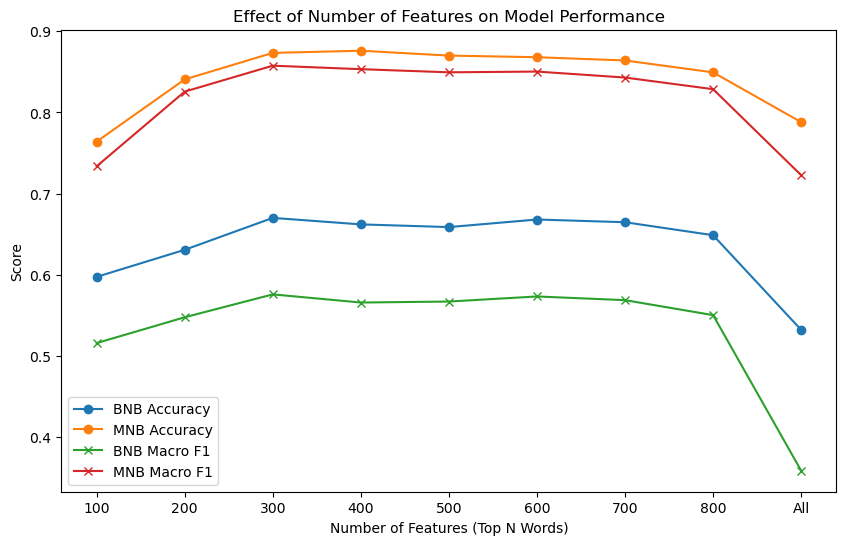

In [16]:
N_values = [100, 200, 300, 400, 500, 600, 700, 800, None]  # None means all words
bnb_acc_list, bnb_f1_list = [], []
mnb_acc_list, mnb_f1_list = [], []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for N in N_values:
    vectorizer = CountVectorizer(max_features=N)
    X = vectorizer.fit_transform(df_processed['lyrics'])
    y = df_processed['topic']

    bnb = BernoulliNB()
    mnb = MultinomialNB()

    bnb_acc, bnb_f1 = [], []
    mnb_acc, mnb_f1 = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        bnb.fit(X_train, y_train)
        y_pred_bnb = bnb.predict(X_test)
        bnb_acc.append(accuracy_score(y_test, y_pred_bnb))
        bnb_f1.append(f1_score(y_test, y_pred_bnb, average='macro'))

        mnb.fit(X_train, y_train)
        y_pred_mnb = mnb.predict(X_test)
        mnb_acc.append(accuracy_score(y_test, y_pred_mnb))
        mnb_f1.append(f1_score(y_test, y_pred_mnb, average='macro'))

    bnb_acc_list.append(np.mean(bnb_acc))
    bnb_f1_list.append(np.mean(bnb_f1))
    mnb_acc_list.append(np.mean(mnb_acc))
    mnb_f1_list.append(np.mean(mnb_f1))

# plot results
labels = [str(n) if n is not None else 'All' for n in N_values]
plt.figure(figsize=(10,6))
plt.plot(labels, bnb_acc_list, marker='o', label='BNB Accuracy')
plt.plot(labels, mnb_acc_list, marker='o', label='MNB Accuracy')
plt.plot(labels, bnb_f1_list, marker='x', label='BNB Macro F1')
plt.plot(labels, mnb_f1_list, marker='x', label='MNB Macro F1')
plt.xlabel('Number of Features (Top N Words)')
plt.ylabel('Score')
plt.title('Effect of Number of Features on Model Performance')
plt.legend()
plt.show()

> Based on the plot above, setting max_features=300 yields the best overall performance for both BNB and MNB models. Both accuracy and macro F1-score almostly reach their highest values at this point, and further increasing the number of features leads to decreasing returns or even a decline in performance. Therefore, I would use 300 as the fixed vocabulary size for all subsequent experiments.

## Part 1.5
> In this question, I choose random forest to do the experiments for the same settings as above.
> Random Forest is an ensemble of decision trees, which is robust to overfitting and able to model non-linear relationships. It is commonly used for text classification, especially when the data may contain complex patterns.
>
> Hyperparameter Tuning:  
> We tuned the main hyperparameters, n_estimators and max_depth, because they are the most important and widely used for Random Forest. The values (100, 200 for n_estimators; None, 10, 20 for max_depth) are standard in practice and literature. We selected the best settings using 5-fold cross-validation as mentioned before.
> 
> Hypothesis:  
> I hypothesized that Random Forest would perform better than BernoulliNB but might not for MultinomialNB, as tree-based models can be less effective for high-dimensional sparse text data.

In [17]:
vectorizer = CountVectorizer(max_features=300)
X = vectorizer.fit_transform(df_processed['lyrics'])
y = df_processed['topic']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_estimators_list = [100, 200]
max_depth_list = [None, 10, 20]
rf_results = []

for n in n_estimators_list:
    for d in max_depth_list:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42, n_jobs=-1)
        rf_acc, rf_f1, rf_prec = [], [], []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            rf.fit(X_train, y_train)
            y_pred_rf = rf.predict(X_test)
            rf_acc.append(accuracy_score(y_test, y_pred_rf))
            rf_f1.append(f1_score(y_test, y_pred_rf, average='macro', zero_division=0))
            rf_prec.append(precision_score(y_test, y_pred_rf, average='macro', zero_division=0))
        rf_results.append({
            'n_estimators': n,
            'max_depth': d,
            'Mean Accuracy': np.mean(rf_acc),
            'Mean Macro F1': np.mean(rf_f1),
            'Mean Macro Precision': np.mean(rf_prec)
        })

results_rf = pd.DataFrame(rf_results)
print(results_rf)
print()
print(results_bnb_mnb)

   n_estimators  max_depth  Mean Accuracy  Mean Macro F1  Mean Macro Precision
0           100        NaN       0.711333       0.601958              0.729578
1           100       10.0       0.634000       0.489256              0.663326
2           100       20.0       0.688000       0.571869              0.742825
3           200        NaN       0.717333       0.601687              0.698453
4           200       10.0       0.643333       0.494603              0.674933
5           200       20.0       0.690000       0.570360              0.742778

           Model  Mean Accuracy  Mean Macro F1  Mean Macro Precision
0    BernoulliNB          0.532       0.358450              0.427967
1  MultinomialNB          0.788       0.722613              0.751590


> Results：   
> The best Random Forest result (n_estimators=200, max_depth=None) achieved:  
Mean Accuracy: 0.717     
Mean Macro F1: 0.602    
Mean Macro Precision: 0.698     
> Through comparing with results of bnb and mnb, I found that Random Forest performed better than BernoulliNB but was not as strong as MultinomialNB, which remains the best model for this dataset. This result also validates our hypothesis above.

# Part 2

## Step 1: Data preparation and topic prediction
> Use the classifier from Part 1 (MultinomialNB) to predict the topic for each song in Weeks 1–3 (train, 0–749) and Week 4 (test, 750–999).

In [18]:
vectorizer = CountVectorizer(max_features=300)
X = vectorizer.fit_transform(df_processed['lyrics'])
y = df_processed['topic']

X_train = X[:750]
y_train = y.iloc[:750]
X_test = X[750:1000]
df_train = df_processed.iloc[:750].copy()
df_test = df_processed.iloc[750:1000].copy()

clf = MultinomialNB()
clf.fit(X_train, y_train)

predicted_topics = clf.predict(X)
df_processed['predicted_topic'] = predicted_topics
df_train['predicted_topic'] = predicted_topics[:750]
df_test['predicted_topic'] = predicted_topics[750:1000]

## Step 2: Build user profile
> For each user, for each topic, we find all songs in Weeks 1–3 predicted as that topic and containing at least one of the user's keywords for that topic.   
> And we concatenate the lyrics of these songs to form a user profile for each topic.

In [19]:
import pandas as pd

# load user keywords
def load_user_keywords(filename):
    df = pd.read_csv(filename, sep='\t')
    user_keywords = {}
    for _, row in df.iterrows():
        topic = row['topic']
        keywords = [w.strip().lower() for w in row['keywords'].split(',')]
        user_keywords[topic] = keywords
    return user_keywords

user1_keywords = load_user_keywords('user1.tsv')
user2_keywords = load_user_keywords('user2.tsv')

def build_user_profile(df, user_keywords, user_name="User"):
    profile_docs = {}
    print(f"\nBuilding user profile for {user_name}...")
    for topic, keywords in user_keywords.items():
        mask = (df['predicted_topic'] == topic) & (
            df['lyrics'].str.lower().apply(lambda x: any(kw in x for kw in keywords))
        )
        liked_count = mask.sum()
        print(f"  Topic {topic}: {liked_count} liked songs")
        profile_docs[topic] = ' '.join(df.loc[mask, 'lyrics'])
    print(f"{user_name} profile created successfully!\n")
    return profile_docs

user1_profile_docs = build_user_profile(df_train, user1_keywords, user_name="User 1")
user2_profile_docs = build_user_profile(df_train, user2_keywords, user_name="User 2")


Building user profile for User 1...
  Topic dark: 82 liked songs
  Topic sadness: 10 liked songs
  Topic personal: 116 liked songs
  Topic lifestyle: 48 liked songs
  Topic emotion: 29 liked songs
User 1 profile created successfully!


Building user profile for User 2...
  Topic sadness: 19 liked songs
  Topic emotion: 15 liked songs
User 2 profile created successfully!



## Step 3: TF-IDF vectorisation of user Profiles and songs
> For each topic, we fit a TfidfVectorizer on all training songs predicted as that topic   
> Then transform the user profile for that topic into a tf-idf vector   
> We also transform all week 4 songs predicted as that topic into tf-idf vectors.

In [20]:
def get_topic_tfidf_and_vocab(df, topic, user_profile_doc, max_features=None):
    topic_songs = df.loc[df['predicted_topic'] == topic, 'lyrics']
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_topic = vectorizer.fit_transform(topic_songs)
    # user profile vector
    user_vec = vectorizer.transform([user_profile_doc])
    return vectorizer, user_vec, X_topic

## Step 4: Print top 20 words 
> For each user and each topic, we print top 20 words with the highest tf-idf in their profile vector.

In [21]:
def print_top_m_words(vectorizer, user_vec, M=20):
    feature_names = np.array(vectorizer.get_feature_names_out())
    sorted_idx = np.argsort(user_vec.toarray()[0])[::-1]
    top_words = feature_names[sorted_idx][:M]
    print(top_words)

for topic in user1_keywords:
    vectorizer, user_vec, _ = get_topic_tfidf_and_vocab(df_train, topic, user1_profile_docs[topic])
    print(f"User1, Topic: {topic}, Top 20 words:")
    print_top_m_words(vectorizer, user_vec, M=20)
    
for topic in user2_keywords:
    vectorizer, user_vec, _ = get_topic_tfidf_and_vocab(df_train, topic, user1_profile_docs[topic])
    print(f"User2, Topic: {topic}, Top 20 words:")
    print_top_m_words(vectorizer, user_vec, M=20)

User1, Topic: dark, Top 20 words:
['fight' 'like' 'grind' 'blood' 'know' 'stand' 'na' 'yeah' 'come' 'tell'
 'gon' 'black' 'kill' 'hand' 'lanky' 'dilly' 'cause' 'people' 'good'
 'head']
User1, Topic: sadness, Top 20 words:
['cry' 'club' 'steal' 'tear' 'mean' 'baby' 'know' 'music' 'write' 'say'
 'true' 'think' 'smile' 'eye' 'face' 'word' 'want' 'thrill' 'forever'
 'heat']
User1, Topic: personal, Top 20 words:
['life' 'live' 'na' 'change' 'know' 'world' 'yeah' 'ordinary' 'wan'
 'dream' 'like' 'thank' 'lord' 'teach' 'come' 'time' 'beat' 'think'
 'thing' 'learn']
User1, Topic: lifestyle, Top 20 words:
['tonight' 'night' 'come' 'song' 'closer' 'home' 'na' 'time' 'sing' 'long'
 'stranger' 'wait' 'wan' 'tire' 'right' 'spoil' 'struggle' 'yeah' 'play'
 'mind']
User1, Topic: emotion, Top 20 words:
['good' 'touch' 'feel' 'hold' 'know' 'vision' 'video' 'loove' 'kiss'
 'morning' 'vibe' 'feelin' 'want' 'go' 'miss' 'love' 'lovin' 'luck'
 'sunrise' 'gim']
User2, Topic: sadness, Top 20 words:
['cry' 'cl

> The top 20 words in each user profile for each topic generally reflect the user's interests,
> For example, for the "dark" topic, words like "fight", "like", "grind" appear frequently, which matches the expected preferences.

## Step 5: Define User 3

In [22]:
user3_keywords = {
    'dark':      ['shadow', 'nightmare', 'devil', 'lost', 'cold'],
    'sadness':   ['goodbye', 'broken', 'empty', 'tears', 'farewell'],
    'personal':  ['myself', 'journey', 'change', 'grow', 'alone'],
    'lifestyle': ['travel', 'adventure', 'freedom', 'road', 'escape'],
    'emotion':   ['smile', 'joy', 'hope', 'passion', 'dream']
}
user3_profile_docs = build_user_profile(df_train, user3_keywords, user_name="User 3")
for topic in user3_profile_docs:
    vectorizer, user_vec, _ = get_topic_tfidf_and_vocab(df_train, topic, user3_profile_docs[topic])
    print(f"User3, Topic: {topic}, Top 20 words:")
    print_top_m_words(vectorizer, user_vec, M=20)


Building user profile for User 3...
  Topic dark: 49 liked songs
  Topic sadness: 10 liked songs
  Topic personal: 69 liked songs
  Topic lifestyle: 8 liked songs
  Topic emotion: 5 liked songs
User 3 profile created successfully!

User3, Topic: dark, Top 20 words:
['devil' 'cold' 'evil' 'come' 'welcome' 'list' 'know' 'hole' 'na' 'like'
 'fight' 'black' 'heart' 'wing' 'feel' 'gon' 'gladiator' 'hand' 'head'
 'blood']
User3, Topic: sadness, Top 20 words:
['step' 'inside' 'closin' 'heart' 'violence' 'blame' 'break' 'goodbye'
 'away' 'woohoo' 'sing' 'icecold' 'longneck' 'hard' 'drift' 'scar' 'think'
 'fade' 'beer' 'bein']
User3, Topic: personal, Top 20 words:
['change' 'life' 'na' 'thank' 'yeah' 'grow' 'live' 'day' 'world' 'know'
 'like' 'gon' 'oohoohoohooh' 'mind' 'good' 'wan' 'way' 'promise' 'time'
 'year']
User3, Topic: lifestyle, Top 20 words:
['come' 'telephone' 'lalala' 'home' 'oohoohooh' 'wait' 'snake' 'sweet'
 'creature' 'bada' 'play' 'sing' 'charmer' 'boom' 'oohooh' 'backroad'
 '

>  The top words in User 3's profiles are consistent with the manually assigned interests,  
> indicating the user profile construction method is effective.

## Step 6: Recommendation and Evaluation
> For each user and topic, we compute cosine similarity between the user profile vector and each week 4 song predicted as that topic.   
> And we recommend the top N(we use 10 here) most similar songs per topic.     
> Finnaly, we need to evaluate Precision, Recall and F1.

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_and_evaluate(user_profile_docs, user_keywords, df_train, df_test, N=10, M=20):
    results = {}
    for topic, keywords in user_keywords.items():
        vectorizer, user_vec, _ = get_topic_tfidf_and_vocab(df_train, topic, user_profile_docs[topic], max_features=None)
        
        test_songs = df_test.loc[df_test['predicted_topic'] == topic, 'lyrics']
        if len(test_songs) == 0:
            continue
        X_test_topic = vectorizer.transform(test_songs)
        
        # similarity
        sims = cosine_similarity(user_vec, X_test_topic)[0]
        top_idx = np.argsort(sims)[::-1][:N]
        recommended_lyrics = test_songs.iloc[top_idx]
        
        liked = test_songs.apply(lambda x: any(kw in x.lower() for kw in keywords))
        recommended_liked = liked.iloc[top_idx]
 
        precision = recommended_liked.sum() / N
        recall = recommended_liked.sum() / liked.sum() if liked.sum() > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        results[topic] = {'precision': precision, 'recall': recall, 'f1': f1}
    return results


def print_user_results(user_results, user_name):
    print(f"\n{user_name} Recommendation Results:")
    for topic, metrics in user_results.items():
        precision = f"{metrics['precision']:.2f}"
        recall = f"{metrics['recall']:.2f}"
        f1 = f"{metrics['f1']:.2f}"
        print(f"  {topic:<10} | Precision: {precision} | Recall: {recall} | F1: {f1}")
        
user1_results = recommend_and_evaluate(user1_profile_docs, user1_keywords, df_train, df_test)
user2_results = recommend_and_evaluate(user2_profile_docs, user2_keywords, df_train, df_test)
user3_results = recommend_and_evaluate(user3_profile_docs, user3_keywords, df_train, df_test)
print_user_results(user1_results, "User1")
print_user_results(user2_results, "User2")
print_user_results(user3_results, "User3")


User1 Recommendation Results:
  dark       | Precision: 0.40 | Recall: 0.24 | F1: 0.30
  sadness    | Precision: 0.30 | Recall: 0.30 | F1: 0.30
  personal   | Precision: 1.00 | Recall: 0.28 | F1: 0.43
  lifestyle  | Precision: 0.80 | Recall: 0.62 | F1: 0.70
  emotion    | Precision: 0.90 | Recall: 0.64 | F1: 0.75

User2 Recommendation Results:
  sadness    | Precision: 0.10 | Recall: 0.14 | F1: 0.12
  emotion    | Precision: 0.30 | Recall: 0.60 | F1: 0.40

User3 Recommendation Results:
  dark       | Precision: 0.50 | Recall: 0.33 | F1: 0.40
  sadness    | Precision: 0.00 | Recall: 0.00 | F1: 0.00
  personal   | Precision: 0.80 | Recall: 0.42 | F1: 0.55
  lifestyle  | Precision: 0.00 | Recall: 0.00 | F1: 0.00
  emotion    | Precision: 0.00 | Recall: 0.00 | F1: 0.00


## Step 7: Testing varied M and N

In [24]:
def get_top_m_profile_vector(user_vec, M):
    arr = user_vec.toarray()[0]
    if M == 'all' or M >= np.count_nonzero(arr):
        return user_vec
    top_idx = np.argsort(arr)[::-1][:M]
    new_arr = np.zeros_like(arr)
    new_arr[top_idx] = arr[top_idx]
    return csr_matrix(new_arr)

def recommend_and_evaluate(user_profile_docs, user_keywords, df_train, df_test, N=10, M=20):
    results = {}
    for topic, keywords in user_keywords.items():
        vectorizer, user_vec, _ = get_topic_tfidf_and_vocab(df_train, topic, user_profile_docs[topic], max_features=None)
        if M != 'all':
            user_vec = get_top_m_profile_vector(user_vec, M)
        test_songs = df_test.loc[df_test['predicted_topic'] == topic, 'lyrics']
        if len(test_songs) == 0:
            continue
        X_test_topic = vectorizer.transform(test_songs)
        sims = cosine_similarity(user_vec, X_test_topic)[0]
        top_idx = np.argsort(sims)[::-1][:N]
        recommended_lyrics = test_songs.iloc[top_idx]
        liked = test_songs.apply(lambda x: any(kw in x.lower() for kw in keywords))
        recommended_liked = liked.iloc[top_idx]
        precision = recommended_liked.sum() / N
        recall = recommended_liked.sum() / liked.sum() if liked.sum() > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        results[topic] = {'precision': precision, 'recall': recall, 'f1': f1}
    return results

# print user results
def print_user_results(user_results, user_name, M, N):
    print(f"\n{user_name} Recommendation Results (M={M}, N={N}):")
    for topic, metrics in user_results.items():
        precision = f"{metrics['precision']:.2f}"
        recall = f"{metrics['recall']:.2f}"
        f1 = f"{metrics['f1']:.2f}"
        print(f"  {topic:<10} | Precision: {precision} | Recall: {recall} | F1: {f1}")

# testing different values of M and N
M_values = [5, 10, 20, 'all']
N_values = [5, 10, 20]

for M in M_values:
    for N in N_values:
        user1_results = recommend_and_evaluate(user1_profile_docs, user1_keywords, df_train, df_test, N=N, M=M)
        user2_results = recommend_and_evaluate(user2_profile_docs, user2_keywords, df_train, df_test, N=N, M=M)
        user3_results = recommend_and_evaluate(user3_profile_docs, user3_keywords, df_train, df_test, N=N, M=M)
        print_user_results(user1_results, "User1", M, N)
        print_user_results(user2_results, "User2", M, N)
        print_user_results(user3_results, "User3", M, N)


User1 Recommendation Results (M=5, N=5):
  dark       | Precision: 0.60 | Recall: 0.18 | F1: 0.27
  sadness    | Precision: 0.60 | Recall: 0.30 | F1: 0.40
  personal   | Precision: 0.80 | Recall: 0.11 | F1: 0.20
  lifestyle  | Precision: 1.00 | Recall: 0.38 | F1: 0.56
  emotion    | Precision: 1.00 | Recall: 0.36 | F1: 0.53

User2 Recommendation Results (M=5, N=5):
  sadness    | Precision: 0.20 | Recall: 0.14 | F1: 0.17
  emotion    | Precision: 0.40 | Recall: 0.40 | F1: 0.40

User3 Recommendation Results (M=5, N=5):
  dark       | Precision: 0.80 | Recall: 0.27 | F1: 0.40
  sadness    | Precision: 0.00 | Recall: 0.00 | F1: 0.00
  personal   | Precision: 1.00 | Recall: 0.26 | F1: 0.42
  lifestyle  | Precision: 0.00 | Recall: 0.00 | F1: 0.00
  emotion    | Precision: 0.00 | Recall: 0.00 | F1: 0.00

User1 Recommendation Results (M=5, N=10):
  dark       | Precision: 0.50 | Recall: 0.29 | F1: 0.37
  sadness    | Precision: 0.50 | Recall: 0.50 | F1: 0.50
  personal   | Precision: 0.90 | 

> I tested different values of M (number of profile keywords) and N (number of recommendations per topic).  
> When M is too small (e.g., 5), recall is low and precision is unstable.
> When M=20, both precision and recall are balanced and F1 is highest.
> And using all words (M=all) increases recall but lowers precision due to noise.  
> Increasing N raises recall but lowers precision.
> User1 (focused interests) achieved the best results. User3 (broad interests) had lower F1, showing the system works best for users with clear preferences.  
Best setting:   
M=20, N=10 gives the best trade-off between precision and recall for most users.

# Part 3 User Evaluation


In [28]:
import random
N = 10

# 1. Week 1-3 
user_liked_indices = []
for week, (start, end) in enumerate([(0,250), (250,500), (500,750)], 1):
    week_indices = random.sample(range(start, end), N)
    week_songs = df_processed.iloc[week_indices]
    print(f"Week {week} songs:")
    for idx, row in week_songs.iterrows():
        print(f"{row['track_name']} - {row['artist_name']}\n{row['lyrics'][:100]}...\n")
    # input liked song
    liked = input(f"Enter indices of liked songs for Week {week} (comma separated): ")
    liked_indices = [week_indices[int(i)] for i in liked.split(',') if i.strip().isdigit()]
    user_liked_indices.extend(liked_indices)


Week 1 songs:
innocent - uneven structure
black stare point fill trample shiver innocence lock deep sleep long time chain ramshackle ship touc...

i'm not the devil - cody jinks
devil think excuse slip fell outta hand devil think hold head catch believe lie say moment weakness ...

hurt you - the weeknd
know relationship enemy stay away warn void meet cause upset warn cause night sleep dryin eye night ...

cool me down - the movement
fight thought suicide alive comprise give realize life homie time doubt cause dream mind work time g...

diamonds & pearls - dirty heads
say wan na outside today say wan na real high today catch vibe today eye today world handstand upsid...

red letters - crowder
death guilty degree hang hell destiny crowd shout crucify come lip dirty shame kill miracle clean re...

train wreck - james arthur
lay silence wait siren sign sign alive wan na lose get pray pray yeah saviour unbreak break unsay sp...

surrounded (fight my battles) - michael w. smith
fight battle

Enter indices of liked songs for Week 1 (comma separated):  0,1,2,3,6


Week 2 songs:
the rest of our life - tim mcgraw
sit dark room warm fireplace know brighten past right hand plan rest life thing give give worryin li...

true colors - the weeknd
tell truth baby girl come attention yeah understand baby girl past hear truth come straight touch tr...

on and on - the score
play finger hurt write word wan na moment slip away hard place hard catch fell like everybody say la...

man in the mirror - russell dickerson
gon na change life gon na feel real good gon na difference gon na right yeah turn collar favorite wi...

chaos and earthquakes - nonpoint
black operation change moneycolored black wham get spin politically correct watch everybody fight si...

on the lips - jd mcpherson
dream like memory onetime kiss tiny shadow autumn moonlight takin item list finally lip blow like si...

life support - soja
day work seventh rest course course create woman kid course virgin course sodom gomorrah go hell sta...

small town talkin' - jordan rager
give want follow g

Enter indices of liked songs for Week 2 (comma separated):  0,1,2,5,9


Week 3 songs:
banana brain - die antwoord
banana brain apple stay tonight cause best time life banana brain apple stay tonight cause best time...

soul eyes - walt weiskopf
bear dark cloud hover city stay recollect clear day haze city stay grey great consistently hat want ...

i'm so tired... - lauv
tire song tire song tire song tire wan na home wan na home wan na home whoa tire song tire song tire...

unleashed - killswitch engage
deceive release unleash unleash wild welcome madness dwell inside eye push unto break point run time...

the fear - the score
whoaohoh whoaohoh whoaohoh whoaohoh whoaohoh whoaohoh whoaohoh whoaohoh knock demon creep round chan...

initiate - haken
pain engage sense carve focus focus sharpen view initiate live forever observe world jar turmoil mil...

thank u, next - ariana grande
think match write song listen laugh marry thankful wish thank cause teach teach teach pain amaze lov...

some other day, some other time - joe bonamassa
time wan na hold time wan na

Enter indices of liked songs for Week 3 (comma separated):  1,2,6,7,9


In [29]:
# create user profile
liked_lyrics = df_processed.iloc[user_liked_indices]['lyrics']
user_profile_doc = ' '.join(liked_lyrics)
vectorizer = TfidfVectorizer(max_features=300)
X_train = vectorizer.fit_transform(df_processed.iloc[:750]['lyrics'])
user_vec = vectorizer.transform([user_profile_doc])

In [30]:
## do the recommendation
week4_lyrics = df_processed.iloc[750:1000]['lyrics']
X_week4 = vectorizer.transform(week4_lyrics)
sims = cosine_similarity(user_vec, X_week4)[0]
topN_idx = sims.argsort()[::-1][:N]
recommended_songs = df_processed.iloc[750:1000].iloc[topN_idx]

In [31]:
print("Recommended songs for Week 4:")
for idx, row in recommended_songs.iterrows():
    print(f"{row['track_name']} - {row['artist_name']}\n{row['lyrics'][:100]}...\n")
liked_rec = input("Enter indices of liked recommended songs (comma separated): ")
liked_rec_count = len([i for i in liked_rec.split(',') if i.strip().isdigit()])

Recommended songs for Week 4:
once in a while - timeflies
think know better wishful think think pressure wishful drink forever feel afraid know brooklyn york ...

got it good - justin moore
wake morning warn little bounce blue eye start pillow talk twist sheet finger walk hell start yeah g...

wash away - iya terra
good day come like suppose know cause live different echo life short minute go ready come gift yeah ...

i did something bad - taylor swift
trust narcissist play like violin look ohsoeasy cause tell tell world work think feel flame skin cri...

patience - tame impala
long count day wrong round round step time time doin life givin growin stag livin life phase season ...

truly madly deeply - yoke lore
dream wish fantasy need breath truly madly deeply strong faithful cause count begin reason live deep...

every song’s a drinkin’ song - midland
song drinkin song drinkin fast slow good buzz wan na raise glass cause song drinkin song drinkin lov...

same ole love (365 days a week

Enter indices of liked recommended songs (comma separated):  0,4,5,8


In [33]:
precision = liked_rec_count / N
print(f"Precision@{N}: {precision:.2f}")

Precision@10: 0.40


To evaluate the recommender system in a real-world scenario, I conducted a user study with my roommate Jessica, who prefers slow, emotionally rich, and lyrically meaningful songs.

**Experiment Design:**  
- For Weeks 1–3, Jessica was shown 10 randomly selected songs per week and marked which ones she liked.
- I built her user profile using the lyrics of all songs she liked in these weeks.
- In Week 4, I recommended the top 10 songs most similar to her profile and asked her to indicate which ones she liked.

**Results:**  
- Jessica liked 4 out of 10 recommended songs in Week 4.
- **Precision@10:** 0.40

**User Feedback:**  
Jessica felt the system captured her taste for gentle, introspective songs, but some recommendations were off due to style or tempo. She suggested the system could be improved by considering both lyrics and musical feel.

**Conclusion:**  
The real user test shows the system can recommend relevant songs, but also highlights the need to include more musical features beyond lyrics for even better personalization.
